In [6]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import time
%matplotlib inline
import sys
sys.path.append('./')

# from intersections_and_roads import *
from final_project import *
# from search import *
from shapely.geometry import *
import ast

**Cambridge Graph**

In [7]:
cambridge_map = map_structure(city='Cambridge')

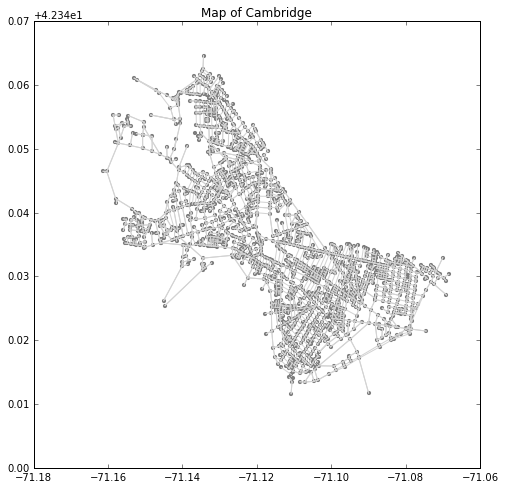

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
cambridge_map.plot_graph(ax=ax)
ax.set_title('Map of Cambridge')
plt.show()

**San Francisco**

In [9]:
san_fran_map = map_structure(city='San Francisco')

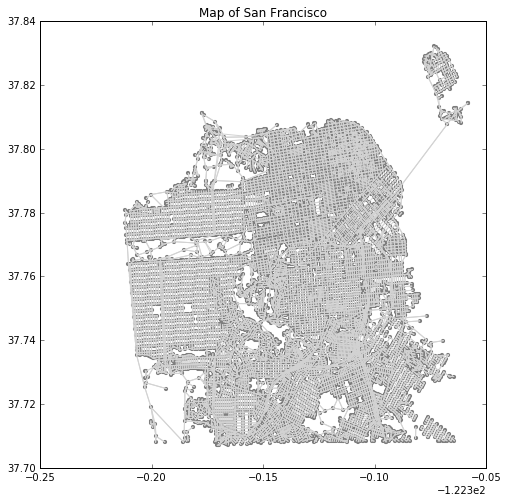

In [10]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
san_fran_map.plot_graph(ax=ax)
ax.set_title('Map of San Francisco')
plt.show()

### Section 1: Graph Search - A*

In [11]:
# randomly select a start and an end point on the graph for test
intersection_graph = san_fran_map.intersection_graph
start = intersection_graph[np.random.choice(intersection_graph.keys())]
end = intersection_graph[np.random.choice(intersection_graph.keys())]

In [12]:
# search the graph
route = san_fran_map.a_star_search(start,
                                   end,
                                   road_cost=san_fran_map.get_road_cost,
                                   heuristic=san_fran_map.null_heuristic)
safe_route = san_fran_map.a_star_search(start,
                                   end,
                                   road_cost=san_fran_map.get_safe_road_cost,
                                   heuristic=san_fran_map.null_heuristic)

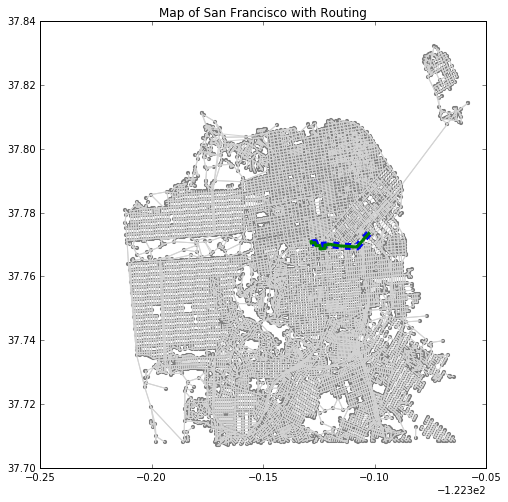

In [13]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
san_fran_map.plot_graph([route['nodes']], [safe_route['nodes']], ax=ax)
ax.set_title('Map of San Francisco with Routing')
plt.show()

**Lets collect some data:**

In [30]:
def sim(start, end, cost_fn, heuristic_fn, map_to_test):
    route, nodes_expanded = map_to_test.a_star_search(start,
                                   end,
                                   road_cost=cost_fn,
                                   heuristic=heuristic_fn,
                                   return_expanded_nodes = True)
    
    solution_distance = map_to_test.get_road_cost(route['nodes'], route['connections'])
    delta_elev = np.sum([map_to_test.road_connections[conn].delta_elevation for conn in route['connections']])
    return (route['nodes'], solution_distance, delta_elev, len(nodes_expanded))

def execute_simulation(nsims, cost_fn, heuristic_fn, map_to_test=san_fran_map):
    euclidean_dist = []
    solution_nodes = [[],[],[]]
    solution_route_distance = [[],[],[]]
    solution_delta_elevation = [[],[],[]]
    solution_nodes_expanded = [[],[],[]]

    for i in range(nsims):
        try:
            start = map_to_test.intersection_graph[np.random.choice(map_to_test.intersection_graph.keys())]
            end = map_to_test.intersection_graph[np.random.choice(map_to_test.intersection_graph.keys())]
            euclid_dist = 0
            while (end.id == start.id) or ((euclid_dist < 0.05) or (euclid_dist > 0.15)):
                end = map_to_test.intersection_graph[np.random.choice(map_to_test.intersection_graph.keys())]
                euclid_dist = euclidean_distance(start.get_x_y(), end.get_x_y())

            # under the null heuristic
            result0 = sim(start, end, cost_fn[0], heuristic_fn[0], map_to_test)

            # under the euclidean_heuristic heuristic
            result1 = sim(start, end, cost_fn[1], heuristic_fn[1], map_to_test)

            # under the combined_heuristic heuristic
            result2 = sim(start, end, cost_fn[2], heuristic_fn[2], map_to_test)
            
            euclidean_dist.append(euclid_dist)
            
            k = 0
            solution_nodes[k].append(result0[0])
            solution_route_distance[k].append(result0[1])
            solution_delta_elevation[k].append(result0[2])
            solution_nodes_expanded[k].append(result0[3])
            
            k = 1
            solution_nodes[k].append(result1[0])
            solution_route_distance[k].append(result1[1])
            solution_delta_elevation[k].append(result1[2])
            solution_nodes_expanded[k].append(result1[3])
            
            k = 2
            solution_nodes[k].append(result2[0])
            solution_route_distance[k].append(result2[1])
            solution_delta_elevation[k].append(result2[2])
            solution_nodes_expanded[k].append(result2[3])
        except:
            print start, end
        
    return euclidean_dist, solution_nodes, solution_route_distance, solution_delta_elevation, solution_nodes_expanded

#watch out for this number. The larger it is the longer this will all take!!! (100 is MASSIVE)
nsim = 100

Basic road cost

In [31]:
# Cost function = get_road_cost ## I.e. simple road cost
cost_fn = [san_fran_map.get_road_cost, san_fran_map.get_road_cost, san_fran_map.get_road_cost]
heuristic = [san_fran_map.null_heuristic, san_fran_map.euclidean_heuristic, san_fran_map.combined_heuristic]

result = execute_simulation(nsim, cost_fn, heuristic, san_fran_map)

euclidean_dist = result[0]
solution_nodes = result[1]
solution_route_distance = result[2]
solution_delta_elevation = result[3]
solution_nodes_expanded = result[4]

<Node> id: 26991000, x: -122.441654967, y: 37.8025104982 
Connections: set([11718000, 11719000, 3686000]) <Node> id: 50800000, x: -122.364277648, y: 37.7084728188 
Connections: set([3726000])


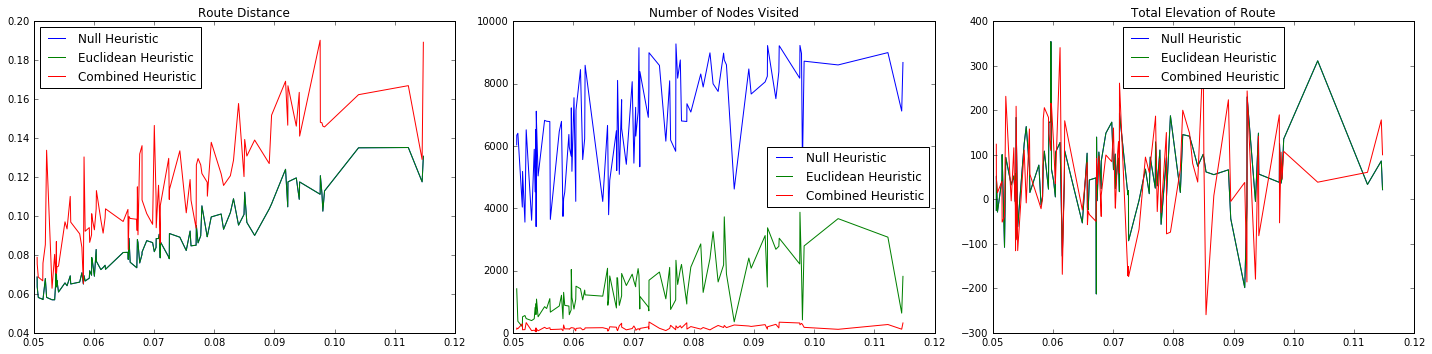

In [33]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

labels = ['Null Heuristic', 'Euclidean Heuristic', 'Combined Heuristic']
arg_sort = np.argsort(euclidean_dist).astype(np.int32)
solution_route_distance = np.array(solution_route_distance)
for i in range(3):
    ax[0].plot(euclidean_dist[arg_sort], solution_route_distance[i][arg_sort], label=labels[i])

solution_nodes_expanded = np.array(solution_nodes_expanded)
for i in range(3):
    ax[1].plot(euclidean_dist[arg_sort], solution_nodes_expanded[i][arg_sort], label=labels[i])
    
solution_delta_elevation = np.array(solution_delta_elevation)
for i in range(3):
    ax[2].plot(euclidean_dist[arg_sort], solution_delta_elevation[i][arg_sort], label=labels[i])

ax[0].set_title('Route Distance')
ax[1].set_title('Number of Nodes Visited')
ax[2].set_title('Total Elevation of Route')

ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')

fig.tight_layout()
plt.show()

Safe Road Cost

In [34]:
# Cost function = euclidean_heuristic ## I.e. simple road cost
cost_fn = [san_fran_map.get_safe_road_cost, san_fran_map.get_safe_road_cost, san_fran_map.get_safe_road_cost]
result = execute_simulation(nsim, cost_fn, heuristic, san_fran_map)

euclidean_dist = result[0]
solution_nodes = result[1]
solution_route_distance = result[2]
solution_delta_elevation = result[3]
solution_nodes_expanded = result[4]

<Node> id: 27574000, x: -122.459323509, y: 37.7875207146 
Connections: set([2415000, 4126000, 2416000]) <Node> id: 51931000, x: -122.369604523, y: 37.7105529828 
Connections: set([12535000, 4903000, 4902000, 12534000])
<Node> id: 26994000, x: -122.443413508, y: 37.8027741388 
Connections: set([9701000, 9702000, 4833000, 4832000]) <Node> id: 51918000, x: -122.385136297, y: 37.708969338 
Connections: set([9931000, 4251000, 4250000, 9930000])
<Node> id: 51638000, x: -122.45293599, y: 37.7402233322 
Connections: set([9232000, 7912000, 9231000]) <Node> id: 50817000, x: -122.370907636, y: 37.7084572714 
Connections: set([6183000])
<Node> id: 50820000, x: -122.36763704, y: 37.7084649875 
Connections: set([5111000]) <Node> id: 27239000, x: -122.462683796, y: 37.7737597519 
Connections: set([5910000, 5911000, 283000])
<Node> id: 27924000, x: -122.505405788, y: 37.7529641106 
Connections: set([9681000, 2026000, 9680000, 2025000]) <Node> id: 50819000, x: -122.368663921, y: 37.7084625749 
Connecti

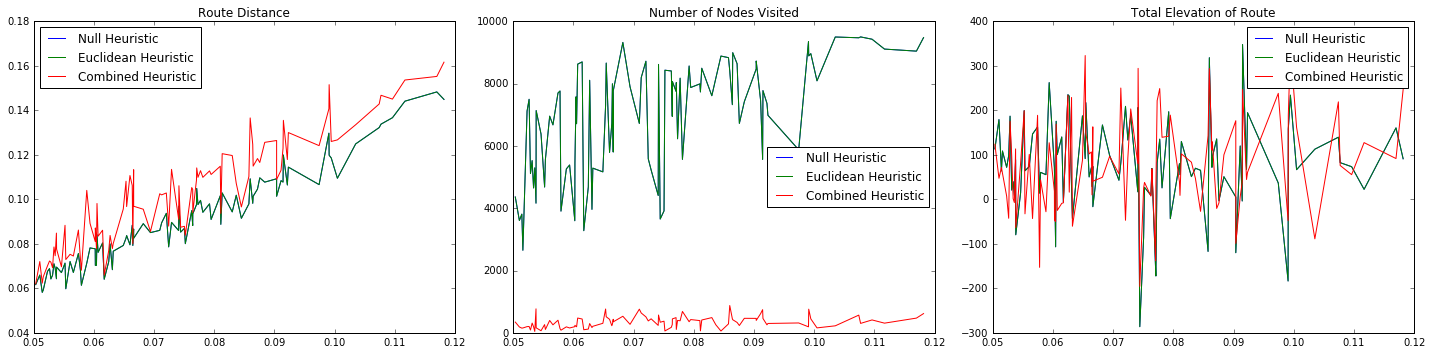

In [35]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

euclidean_dist = np.array(euclidean_dist)
labels = ['Null Heuristic', 'Euclidean Heuristic', 'Combined Heuristic']
arg_sort = np.argsort(euclidean_dist).astype(np.int32)

solution_route_distance = np.array(solution_route_distance)
for i in range(3):
    ax[0].plot(euclidean_dist[arg_sort], solution_route_distance[i][arg_sort], label=labels[i])

solution_nodes_expanded = np.array(solution_nodes_expanded)
for i in range(3):
    ax[1].plot(euclidean_dist[arg_sort], solution_nodes_expanded[i][arg_sort], label=labels[i])
    
solution_delta_elevation = np.array(solution_delta_elevation)
for i in range(3):
    ax[2].plot(euclidean_dist[arg_sort], solution_delta_elevation[i][arg_sort], label=labels[i])

ax[0].set_title('Route Distance')
ax[1].set_title('Number of Nodes Visited')
ax[2].set_title('Total Elevation of Route')

ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')

fig.tight_layout()
plt.show()

Safe Road Cost with Elevation

In [36]:
# Cost function = euclidean_heuristic ## I.e. simple road cost
cost_fn = [san_fran_map.get_safe_road_cost_with_elevation,
           san_fran_map.get_safe_road_cost_with_elevation,
           san_fran_map.get_safe_road_cost_with_elevation]
result = execute_simulation(nsim, cost_fn, heuristic, san_fran_map)

euclidean_dist = result[0]
solution_nodes = result[1]
solution_route_distance = result[2]
solution_delta_elevation = result[3]
solution_nodes_expanded = result[4]

<Node> id: 24987000, x: -122.406821216, y: 37.7941979574 
Connections: set([13464000, 4089000]) <Node> id: 51163000, x: -122.475430265, y: 37.7280027272 
Connections: set([9265000])
<Node> id: 20234000, x: -122.387128522, y: 37.7450704402 
Connections: set([3376000, 199201, 198101]) <Node> id: 51163000, x: -122.475430265, y: 37.7280027272 
Connections: set([9265000])
<Node> id: 53051000, x: -122.358327894, y: 37.8143733948 
Connections: set([]) <Node> id: 20868000, x: -122.409514686, y: 37.7234303477 
Connections: set([13730000, 13729000, 3045000])
<Node> id: 50849000, x: -122.389150054, y: 37.7084125666 
Connections: set([11015000]) <Node> id: 25800000, x: -122.432279516, y: 37.7642889648 
Connections: set([744000, 10590000, 745000])


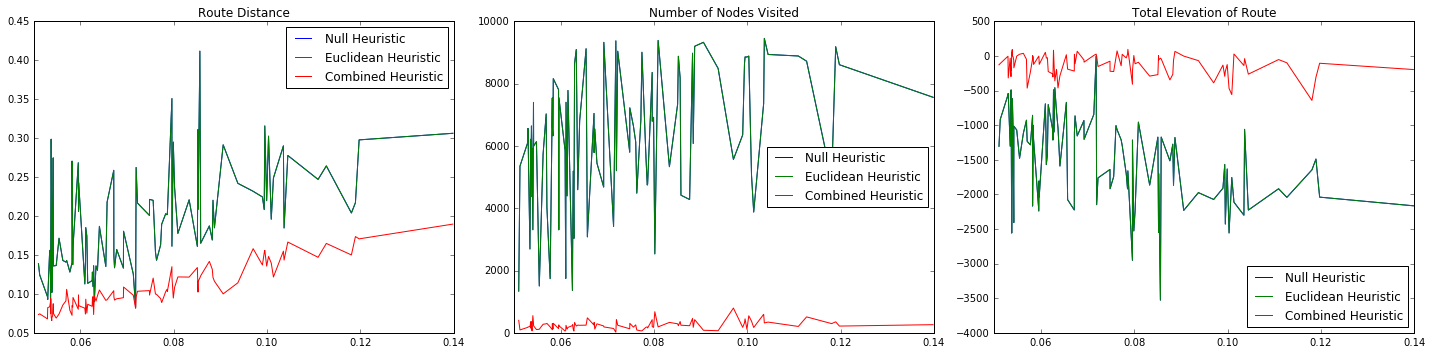

In [37]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

euclidean_dist = np.array(euclidean_dist)
labels = ['Null Heuristic', 'Euclidean Heuristic', 'Combined Heuristic']
arg_sort = np.argsort(euclidean_dist).astype(np.int32)

solution_route_distance = np.array(solution_route_distance)
for i in range(3):
    ax[0].plot(euclidean_dist[arg_sort], solution_route_distance[i][arg_sort], label=labels[i])

solution_nodes_expanded = np.array(solution_nodes_expanded)
for i in range(3):
    ax[1].plot(euclidean_dist[arg_sort], solution_nodes_expanded[i][arg_sort], label=labels[i])
    
solution_delta_elevation = np.array(solution_delta_elevation)
for i in range(3):
    ax[2].plot(euclidean_dist[arg_sort], solution_delta_elevation[i][arg_sort], label=labels[i])

ax[0].set_title('Route Distance')
ax[1].set_title('Number of Nodes Visited')
ax[2].set_title('Total Elevation of Route')

ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')

fig.tight_layout()
plt.show()

In [38]:
cost_fn = [cambridge_map.get_road_cost, cambridge_map.get_safe_road_cost, cambridge_map.get_safe_road_cost_with_elevation]
heuristic = [cambridge_map.null_heuristic, cambridge_map.null_heuristic, cambridge_map.null_heuristic]

result = execute_simulation(20, cost_fn, heuristic, cambridge_map)

euclidean_dist = result[0]
solution_nodes = result[1]
solution_route_distance = result[2]
solution_delta_elevation = result[3]
solution_nodes_expanded = result[4]

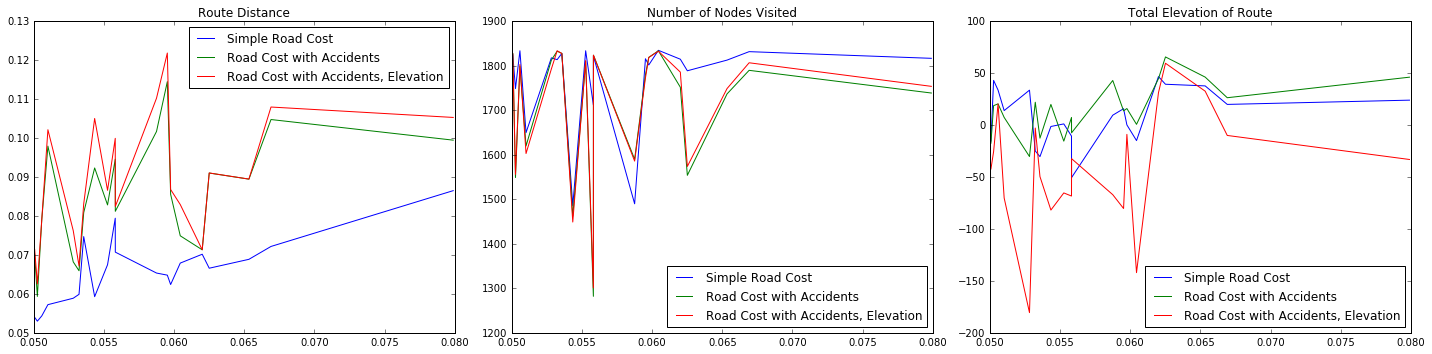

In [39]:
## Compare cost function 
fig, ax = plt.subplots(1,3, figsize=(20,5))

euclidean_dist = np.array(euclidean_dist)
labels = ['Simple Road Cost', 'Road Cost with Accidents', 'Road Cost with Accidents, Elevation']
arg_sort = np.argsort(euclidean_dist).astype(np.int32)

solution_route_distance = np.array(solution_route_distance)
for i in range(3):
    ax[0].plot(euclidean_dist[arg_sort], solution_route_distance[i][arg_sort], label=labels[i])

solution_nodes_expanded = np.array(solution_nodes_expanded)
for i in range(3):
    ax[1].plot(euclidean_dist[arg_sort], solution_nodes_expanded[i][arg_sort], label=labels[i])
    
solution_delta_elevation = np.array(solution_delta_elevation)
for i in range(3):
    ax[2].plot(euclidean_dist[arg_sort], solution_delta_elevation[i][arg_sort], label=labels[i])

ax[0].set_title('Route Distance')
ax[1].set_title('Number of Nodes Visited')
ax[2].set_title('Total Elevation of Route')

ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')

fig.tight_layout()
plt.show()

### Local Search: Simulated Annealing, K-Beam

In [6]:
intersection_graph = cambridge_map.intersection_graph
start = intersection_graph[np.random.choice(intersection_graph.keys())]
end = intersection_graph[np.random.choice(intersection_graph.keys())]

route = cambridge_map.a_star_search(start, end, cambridge_map.get_road_cost, cambridge_map.null_heuristic)

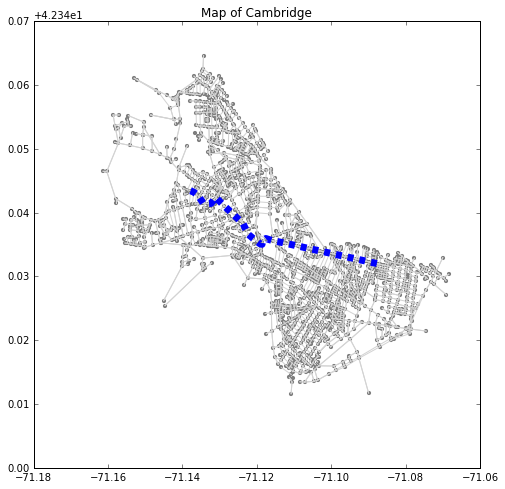

In [7]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
cambridge_map.plot_graph([route['nodes']], ax=ax)
ax.set_title('Map of Cambridge')
plt.show()

In [5]:
# define which map type you want to run
test_map = san

p1 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
p2 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
p3 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
p4 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
points = [p1,p2,p3,p4]

heuristic_fns = [test_map.null_heuristic, test_map.euclidean_heuristic, test_map.combined_heuristic]
times_annealing = []
times_k_beam = []
costs_annealing = []
costs_k_beam = []

for fn in heuristic_fns:
    timer = start - time.clock()
    node_annealing = test_map.simulated_annealing(
                cost_function=test_map.get_safe_road_cost_with_elevation,
                heuristic=test_map.null_heuristic,
                starting_points=points)
    timer_annealing = start - time.clock()
    times_annealing.append(timer_annealing)
    cost = np.sum([test_map.cost(p, node_annealing, test_map.get_road_cost, test_map.null_heuristic) for p in points])
    costs_annealing.append(cost)
    
    timer = start - time.clock()
    node_k_beam = test_map.k_beam_search(k=5,
                cost_function=test_map.get_safe_road_cost_with_elevation,
                heuristic=test_map.null_heuristic,
                starting_points=points)
    timer_k_beam = start - time.clock()
    times_k_beam.append(timer_k_beam)
    cost = np.sum([test_map.cost(p, node_k_beam, test_map.get_road_cost, test_map.null_heuristic) for p in points])
    costs_k_beam.append(cost)
# Sorry I am not sure why this is breaking by I am exhausted... :(

iteration  0 best cost 2560.68879626


AttributeError: 'tuple' object has no attribute 'id'

In [ ]:
# I think maybe a bar chart? Not sure

In [4]:
test_map = cambridge_map

p1 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
p2 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
p3 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
p4 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
points = [p1,p2,p3,p4]

times = []
costs_k_beam = []
ks = np.linspace(5,35,10)

for k in ks:
    k = int(k)
    start = time.clock()
    node_k_beam = test_map.k_beam_search(k=k,
                cost_function=test_map.get_safe_road_cost_with_elevation,
                heuristic=test_map.null_heuristic,
                starting_points=points)

    timer = start - time.clock()
    cost = np.sum([test_map.cost(p, node_k_beam, test_map.get_road_cost, test_map.null_heuristic) for p in points])
    times.append(timer)
    costs.append(cost)
# same comment here

iteration  0 best cost 1951.20813454
iteration  1 best cost 1848.98002698
iteration  2 best cost 1709.5480261
iteration  3 best cost 1585.70198196


AttributeError: 'tuple' object has no attribute 'id'